# Comparison of various discontinuous Galerkin techniques for the advection equation

In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import simplesimdb as simplesim # this one is our own database manager
import itertools
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [2]:
m = simplesim.Manager(directory='advection', executable='./execute.sh', filetype='nc')
content = m.table()

In [3]:
# Construct the Gaussian weights on our grids
def gauss_weights( js) :
    n = js["n"]
    Nx = js["Nx"]
    Ny = js["Ny"]
    lx = js["x"][1]-js["x"][0]
    ly = js["y"][1]-js["y"][0]
    hx = lx/Nx
    hy = ly/Ny
    (x,w) = np.polynomial.legendre.leggauss(js["n"])
    weights1dX = np.tile( w, js["Nx"])
    weights1dY = np.tile( w, js["Ny"])
    return np.reshape( np.kron( weights1dY, weights1dX)*hy/2.0*hx/2.0 , (js["n"]*js["Ny"], js["n"]*js["Nx"]))

In [4]:
# Let's creat a nice lookup table in pandas and also add some diagnostics
last_out = list()
for f in content :
    ncin = Dataset( m.select(f), 'r', format="NETCDF4")
    # time, xc, yc, vorticity, potential,
    # error(t), time_per_step(t), energy_1d(t), enstrophy_1d(t), vorticity_1d(t)
    max_idx = ncin.variables["time"].shape[0]-1
    vo = ncin["vorticity"][:,:,:]
    weights = gauss_weights( f["grid"])
    tps = ncin["time_per_step"][:]
    ene = ncin["energy_1d"][:]
    ens = ncin["enstrophy_1d"][:]
    vor = ncin["vorticity_1d"][:]
    vor20 = 1./2.*np.sum( vo[0,:,:]**2*weights )
    vor21 = 1./2.*np.sum( vo[max_idx,:,:]**2*weights )
    vor40 = 1./4.*np.sum( vo[0,:,:]**4*weights )
    vor41 = 1./4.*np.sum( vo[max_idx,:,:]**4*weights )
    vor60 = 1./6.*np.sum( vo[0,:,:]**6*weights )
    vor61 = 1./6.*np.sum( vo[max_idx,:,:]**6*weights )
    e = dict()
    e["id"] = m.hashinput(f)
    e["error"] = {"solution" : float(ncin["error"][max_idx])}
    e["error"]["vorticity2"] = abs( vor20-vor21)/vor20 # same as enstrophy
    e["error"]["vorticity4"] = abs( vor40-vor41)/vor40 
    e["error"]["vorticity6"] = abs( vor60-vor61)/vor60 
    e["error"]["enstrophy"] = abs(ens[max_idx]-ens[0])/ens[0]
    e["error"]["energy"] = abs(ene[max_idx]-ene[0])/ene[0]
    e["error"]["vorticity"] = abs(vor[max_idx]-vor[0])
    
    e["time_to_solution"] = np.sum(tps)*float(f["output"]["itstp"])
    last_out.append(e)

In [5]:
df = pd.json_normalize( last_out)
df.set_index( "id", inplace=True)
df

,time_to_solution,error.solution,error.vorticity2,error.vorticity4,error.vorticity6,error.enstrophy,error.energy,error.vorticity
id,,,,,,,,
c36cf6b759d7e0ef96ecdc264d95647116fa5efc,4.86e+01,0.00e+00,2.20e-01,3.79e-01,4.01e-01,2.20e-01,7.42e-04,1.67e-09
bb7d5c679271d712914386da9f33f0bd34282715,1.69e+02,0.00e+00,1.19e-01,2.64e-01,2.61e-01,1.19e-01,6.05e-04,3.29e-09
dad0aa7d680db7abd33424d63e967a76dfe76f13,1.10e+00,1.36e-02,4.51e-03,1.55e-02,2.71e-02,4.51e-03,5.37e-03,2.14e-10
93573d0a0852e6236d1e24dc67483d8281557480,7.68e+00,0.00e+00,1.85e-01,2.60e-01,1.25e-01,1.85e-01,9.22e-04,4.79e-15
e3122c1b8e4191b331ca01d3982c13f594f80888,1.41e+01,2.10e-03,8.13e-06,7.19e-05,1.73e-04,8.13e-06,3.86e-06,5.22e-16
...,...,...,...,...,...,...,...,...
94097f23e0ffcaee09011134b3bd9aebf0dab97c,1.16e+01,9.61e-02,3.47e-02,7.45e-02,1.08e-01,3.47e-02,2.58e-02,1.04e-04
45e392d3a1079ca5e4747ef77a30cef026b7a6b1,7.61e+01,9.60e-02,3.47e-02,7.45e-02,1.08e-01,3.47e-02,2.58e-02,5.02e-16
b4e5eba97e0f87e02c40314a90146937874128db,4.18e+01,1.16e-03,1.65e-06,1.18e-05,1.27e-05,1.65e-06,7.82e-07,1.59e-12


In [6]:
def plot (f, save) :
    ncin = Dataset( m.select(f), 'r', format="NETCDF4")
    # time, xc, yc, vorticity, potential,
    # error(t), time_per_step(t), energy_1d(t), enstrophy_1d(t), vorticity_1d(t)
    max_idx = ncin.variables["time"].shape[0]-1
    xc = ncin["xc"][:,:]
    yc = ncin["yc"][:,:]
    vo = ncin["vorticity"][max_idx,:,:]
    po = ncin["potential"][max_idx,:,:]
    time = ncin["time"][:]
    max_idx = np.size( time)-1
    fig,ax=plt.subplots(1,2,figsize=(2*4,4),dpi= 80, facecolor='w', edgecolor='k')

    ax[0].pcolormesh(xc,yc,vo, vmin=-7, vmax=7, shading='gouraud', cmap='seismic' )
    ax[0].set_title( f["grid"]["n"])
    ax[0].axis('scaled')
    viscous = f["regularization"]["type"] == "viscosity"
    modal  = f["regularization"]["type"] == "modal"
    mms = f["init"]["type"] == "mms"
    hashed = m.hashinput(f)
    textstr = '\n'.join((
    r'$%.d \times %.d \times %d $' % (f["grid"]["n"], f["grid"]["Nx"],
                                      f["output"]["itstp"]*f["output"]["maxout"] ),
    #r'$n=%.d\ N=%.d$' % (f["grid"]["n"], f["grid"]["Nx"] ),
    r'$\varepsilon=%.2e$' % (df.loc[hashed,"error.solution"] ) if mms else '',
    r'$\varepsilon_E=%.2e$' % (df.loc[hashed,"error.energy"] ),
    r'$\varepsilon_V=%.2e$' % (df.loc[hashed,"error.vorticity"] ),
    r'$\varepsilon_{V2}=%.2e$' % (df.loc[hashed,"error.vorticity2"] ),
    r'$\varepsilon_{V4}=%.2e$' % (df.loc[hashed,"error.vorticity4"] ),
    r'$\varepsilon_{V6}=%.2e$' % (df.loc[hashed,"error.vorticity6"] ),   
    r'$T_\mathrm{sim}=%.2f$' % (df.loc[hashed,"time_to_solution"] ),
        '',
    'multiplication: ' + f["advection"]["multiplication"] ,
    'advection      : ' + f["advection"]["type"] ,
    'regularization: ' + f["regularization"]["type"] + (
        "("+str(f["regularization"]["order"])+")"  if viscous else 
        r"$\ (\eta_c=%.1f$"%f["regularization"]["eta_c"]+")" if modal else ""
    ), 
    ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[1].text(0.05, 0.95, textstr, transform=ax[1].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
    #ax[1].set_title( f["grid"]["n"])
    ax[1].axis('off')
    if save :
        plt.savefig( "advection/"+hashed+".png",bbox_inches='tight')
        plt.close()
    else :
        pass

In [7]:
# PLOT ALL INTO FILE
#for f in content:
#    plot(f,True)

Let us now tell a story

## No regularization

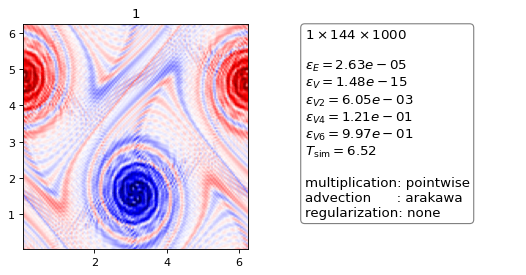

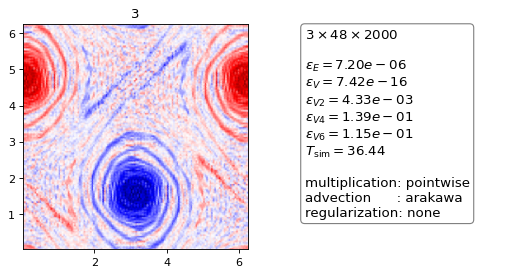

In [8]:
found = list(filter( lambda entry : (
            entry["init"]["type"] == "shear"
        and entry["advection"] == {"multiplication": "pointwise", "type" : "arakawa"}
        and entry["regularization"]["type"] == "none"
        and (entry["grid"]["n"] == 1 or entry["grid"]["n"] == 3)
       ),
    content))
found.sort( key = lambda f : f["grid"]["n"]) # SORT ACCORDING TO N
for f in found:
    plot(f, False)

- The Arakawa scheme without regularization is always unstable!!
- Note that the higher order simulation takes 5-6 times longer to complete

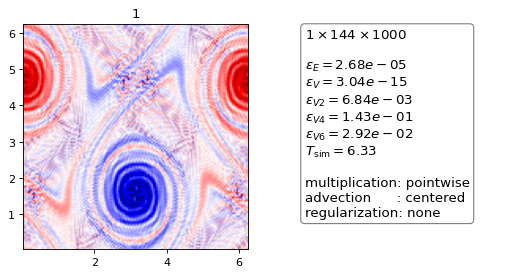

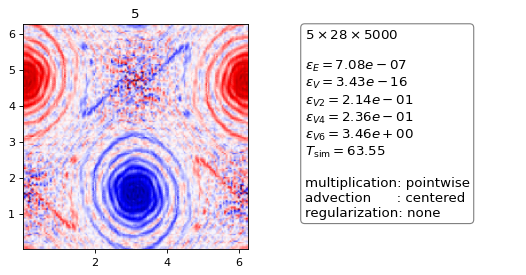

In [9]:
found = list(filter( lambda entry : (
            entry["init"]["type"] == "shear"
        and entry["advection"] == {"multiplication": "pointwise", "type" : "centered"}
        and entry["regularization"]["type"] == "none" # and entry["regularization"]["order"] == 2):
        and (entry["grid"]["n"] == 1 or entry["grid"]["n"] == 5)
       ),
    content))
found.sort( key = lambda f : f["grid"]["n"]) # SORT ACCORDING TO N
for f in found:
    plot(f, False)

Just as the centered scheme is

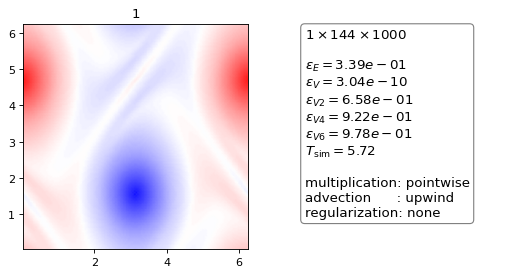

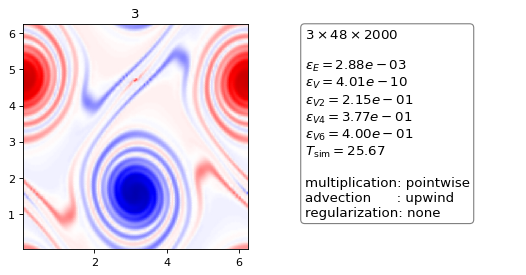

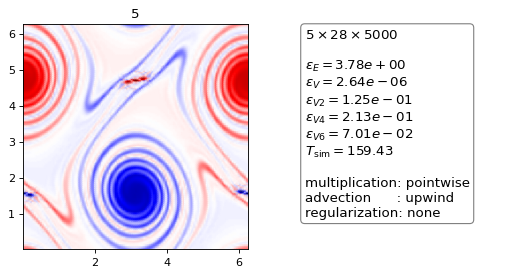

In [10]:
found = list(filter( lambda entry : (
            entry["init"]["type"] == "shear"
        and entry["advection"] == {"multiplication": "pointwise", "type" : "upwind"}
        and entry["regularization"]["type"] == "none" # and entry["regularization"]["order"] == 2):
        and (entry["grid"]["n"] == 1 or entry["grid"]["n"] == 3 or entry["grid"]["n"] == 5)
       ),
    content))
found.sort( key = lambda f : f["grid"]["n"]) # SORT ACCORDING TO N
for f in found:
    plot(f, False)

The upwind scheme of first order introduces a lot of numerical diffusion, while the higher order schemes with pointwise multiplication seem to be unstable at symmetry points

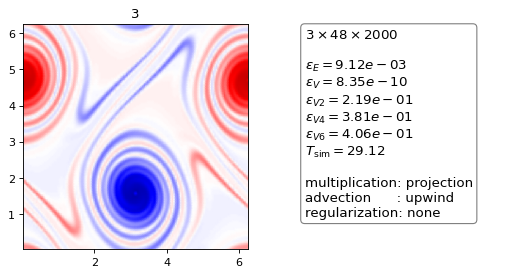

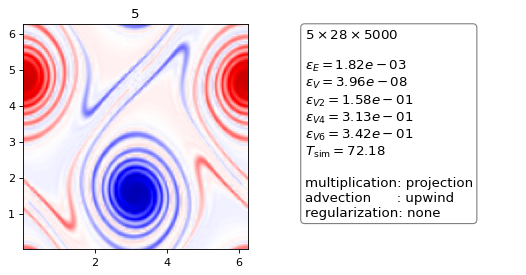

In [11]:
found = list(filter( lambda entry : (
            entry["init"]["type"] == "shear"
        and entry["advection"] == {"multiplication": "projection", "type" : "upwind"}
        and entry["regularization"]["type"] == "none" # and entry["regularization"]["order"] == 2):
        and (entry["grid"]["n"] == 3 or entry["grid"]["n"] == 5)
       ),
    content))
found.sort( key = lambda f : f["grid"]["n"]) # SORT ACCORDING TO N
for f in found:
    plot(f, False)

Only the upwind scheme with correct multiplication and projection of polynomials seems to work reliably without regularization. Only small oscillations are visible.

## Modal filtering

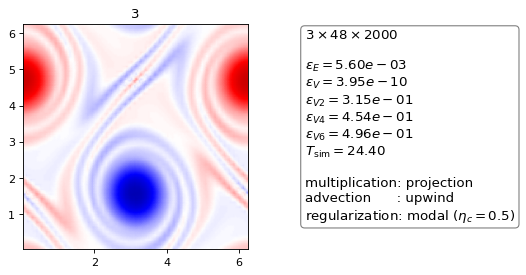

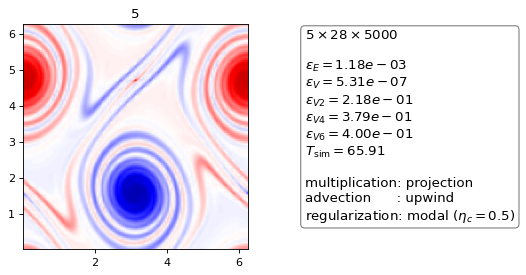

In [12]:
found = list(filter( lambda entry : (
            entry["init"]["type"] == "shear"
        and entry["advection"] == {"multiplication": "projection", "type" : "upwind"}
        and ( #(entry["regularization"]["type"] == "modal" and entry["regularization"]["eta_c"] == 0.0)
             (entry["regularization"]["type"] == "modal" and entry["regularization"]["eta_c"] == 0.5)
            )
        and (entry["grid"]["n"] == 3 or entry["grid"]["n"] == 5)
       ),
    content))
found.sort( key = lambda f : f["grid"]["n"]) # SORT ACCORDING TO N
for f in found:
    plot(f, False)

- The modal Filter introduces numerical diffusion but seems to have troubles at the symmetry points
- also true for $\eta_c = 0$ filter and the pointwise method

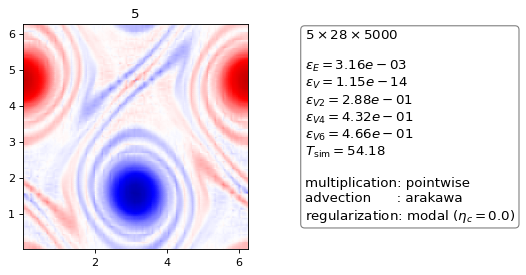

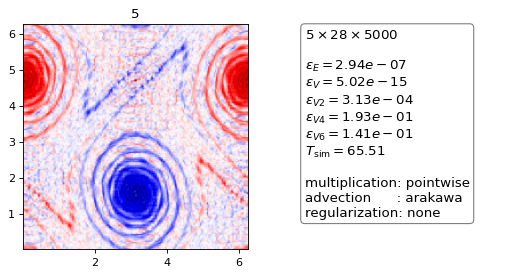

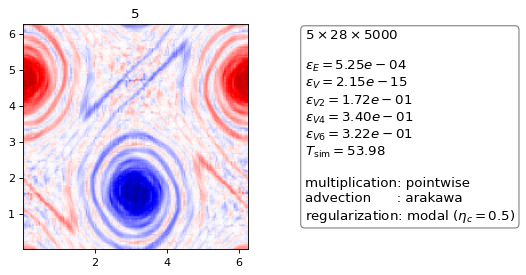

In [13]:
found = list(filter( lambda entry : (
            entry["init"]["type"] == "shear"
        and (entry["advection"] == {"multiplication": "pointwise", "type" : "arakawa"})
            #or entry["advection"] == {"multiplication": "projection", "type" : "centered"})
        and ( (entry["regularization"]["type"] == "modal" and entry["regularization"]["eta_c"] == 0.0)
             or (entry["regularization"]["type"] == "modal" and entry["regularization"]["eta_c"] == 0.5)
             or entry["regularization"]["type"] == "none")
        and (entry["grid"]["n"] == 5)
       ),
    content))
found.sort( key = lambda f : f["grid"]["n"]) # SORT ACCORDING TO N
for f in found:
    plot(f, False)

- The modal filter with $\eta_c=0.5$, $s=8$ and $\alpha=36$ improves the oscillations in the Arakawa scheme but does not entirely remove them
- The modal filter with $\eta_c=0.0$, $s=8$ and $\alpha=36$ further dampens the oscillations but overdampens the vortex structure while still having trouble at the symmetry points
- This situation is the same for the projection and the centered methods

## Viscosity and hyperviscosity